# IMPORT LIBRARIES

In [54]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# LOAD DATASET

In [55]:
df = pd.read_csv('hmeq_train.csv')
df.head(5)

,id,default,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,16537,0,20900,58299.0,78684.00,DebtCon,NaN,3.0,0.0,0.0,98.662820,0.0,16.0,38.972004
1,14800,0,17400,56111.0,114521.00,HomeImp,Office,2.0,NaN,2.0,154.855524,1.0,24.0,38.695084
2,11317,0,8700,57254.0,86883.00,HomeImp,Other,16.0,0.0,0.0,172.166563,0.0,28.0,25.043437
3,13023,0,6000,69876.0,94394.07,HomeImp,Other,0.0,0.0,1.0,179.566667,0.0,32.0,NaN
4,11652,0,9700,75566.0,92066.00,DebtCon,Office,14.0,0.0,0.0,94.987922,0.0,8.0,25.161183


# EDA

## Understand dataset structures

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5198 entries, 0 to 5197
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5198 non-null   int64  
 1   default             5198 non-null   int64  
 2   loan_amount         5198 non-null   int64  
 3   mortgage_amount     4747 non-null   float64
 4   property_value      5103 non-null   float64
 5   loan_reason         4975 non-null   object 
 6   occupation          4957 non-null   object 
 7   occupation_length   4748 non-null   float64
 8   derogatory_reports  4579 non-null   float64
 9   late_payments       4695 non-null   float64
 10  oldest_credit_line  4931 non-null   float64
 11  recent_credit       4762 non-null   float64
 12  credit_number       5002 non-null   float64
 13  ratio               4085 non-null   float64
dtypes: float64(9), int64(3), object(2)
memory usage: 568.7+ KB


In [57]:
df.columns

Index(['id', 'default', 'loan_amount', 'mortgage_amount', 'property_value',
       'loan_reason', 'occupation', 'occupation_length', 'derogatory_reports',
       'late_payments', 'oldest_credit_line', 'recent_credit', 'credit_number',
       'ratio'],
      dtype='object')

- Here we have 14 variables with 5198 observations in total.  
- Target variable: 'default'
- Numerical variables: 'loan_amount', 'mortgage_amount', 'property_value', 'occupation_length', 
          'derogatory_reports', 'late_payments', 'oldest_credit_line', 'recent_credit', 
          'credit_number', 'ratio'  
- Categorical variables: 'loan_reason', 'occupation'

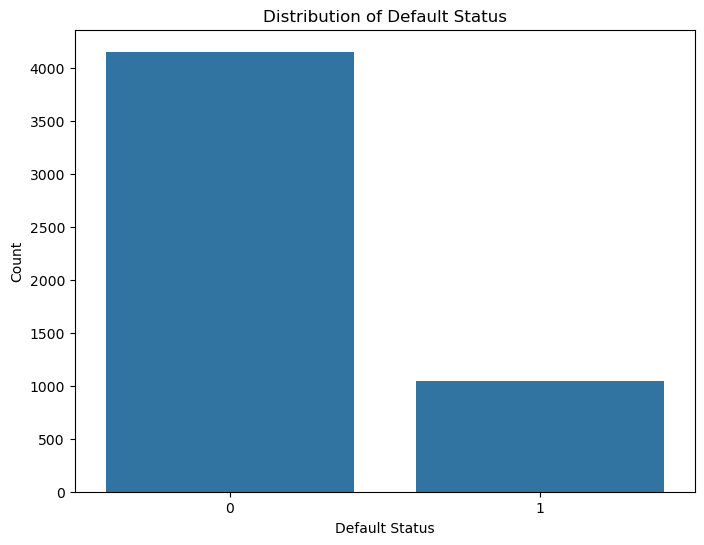

In [58]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'default', data = df)
plt.title('Distribution of Default Status')
plt.xlabel('Default Status')
plt.ylabel('Count')
plt.show()

In [59]:
df.describe()

,id,default,loan_amount,mortgage_amount,property_value,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
count,5198.000000,5198.000000,5198.000000,4747.000000,5103.000000,4748.000000,4579.000000,4695.000000,4931.000000,4762.000000,5002.000000,4085.000000
mean,13979.209311,0.200462,18701.923817,73830.992262,101741.681450,8.915912,0.250273,0.441747,179.341253,1.175766,21.334066,33.812989
std,1720.084497,0.400384,11319.689848,44312.704222,56597.298276,7.551801,0.837519,1.117683,84.711299,1.715044,10.180620,8.666731
min,11001.000000,0.000000,1100.000000,2619.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,12490.250000,0.000000,11100.000000,46361.000000,66265.500000,3.000000,0.000000,0.000000,114.906479,0.000000,14.250000,29.200400
50%,13984.500000,0.000000,16400.000000,65205.000000,89553.000000,7.000000,0.000000,0.000000,173.574416,1.000000,20.000000,34.889242
75%,15467.750000,0.000000,23300.000000,91701.500000,120000.000000,13.000000,0.000000,0.000000,231.152689,2.000000,26.000000,39.002928
max,16960.000000,1.000000,89900.000000,399550.000000,854114.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [60]:
num_col = df[['loan_amount', 'mortgage_amount', 'property_value', 'occupation_length', 
          'derogatory_reports', 'late_payments', 'oldest_credit_line', 'recent_credit', 
          'credit_number', 'ratio']]
categorical_col = df[['loan_reason', 'occupation']]

## Check for missing values and duplicates

In [62]:
df.shape

(5198, 14)

In [63]:
df.isna().sum()

id                       0
default                  0
loan_amount              0
mortgage_amount        451
property_value          95
loan_reason            223
occupation             241
occupation_length      450
derogatory_reports     619
late_payments          503
oldest_credit_line     267
recent_credit          436
credit_number          196
ratio                 1113
dtype: int64

In [64]:
df.duplicated().sum()

0

It appears that our dataset contains a lot of missing values for the majority of variables. I'll visualize this to have a clearer view

### Visualizing missing values

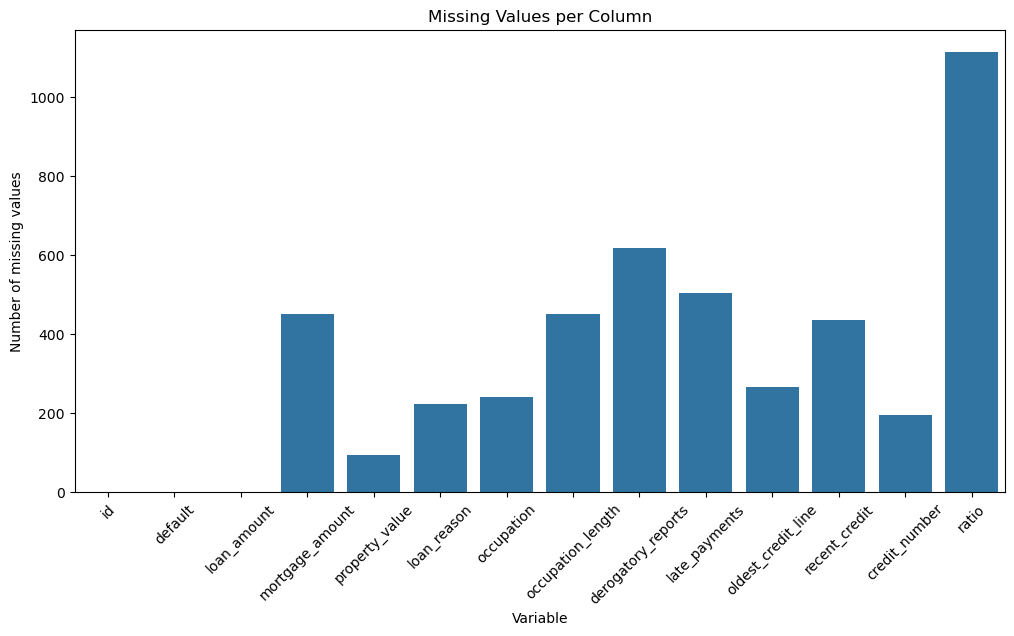

In [65]:
missing_counts = df.isna().sum()
missing_counts = pd.DataFrame({
     'Variable': missing_counts.index,
     'Missing count': missing_counts.values
})

plt.figure(figsize=(12,6))
sns.barplot(x = 'Variable',
            y = 'Missing count',
            data= missing_counts
            )
plt.xticks(rotation = 45)
plt.ylabel('Number of missing values')
plt.title('Missing Values per Column')
plt.show()

## Bivariate Analysis

### Correlation

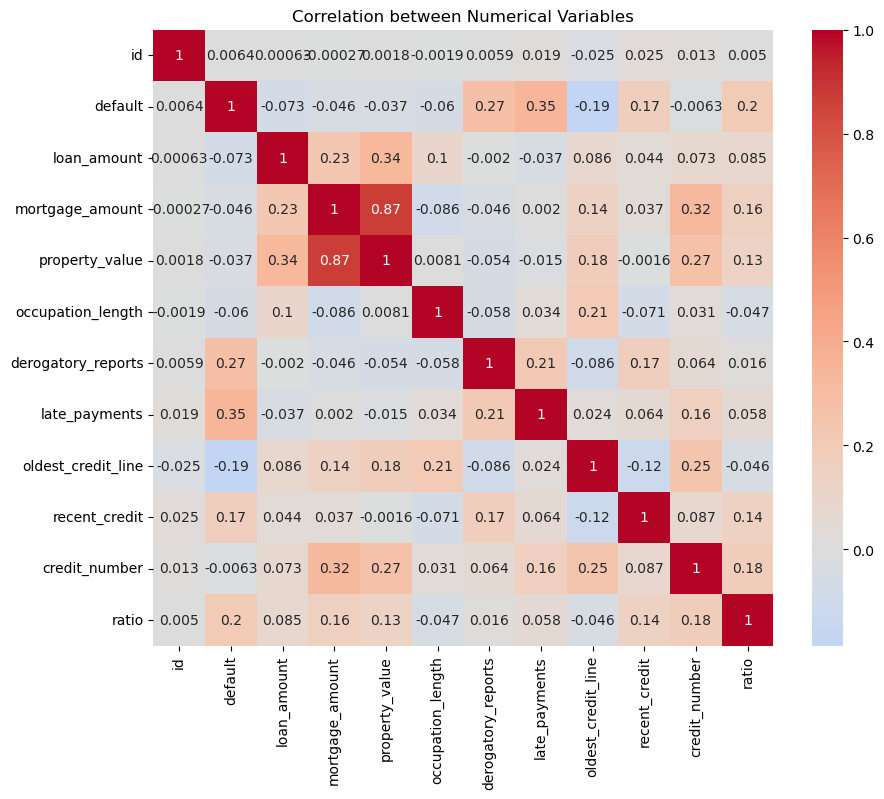

In [66]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', center=0)
plt.title('Correlation between Numerical Variables')
plt.show()

In [67]:
corr_pairs = corr.unstack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlation
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

# Drop duplicates pairs (A-B same as B-A)
corr_pairs['Pairs'] = corr_pairs.apply(
     lambda x: '-'.join(sorted(
          [x['Feature1'], x['Feature2']]
     )), axis = 1
)
corr_pairs = corr_pairs.drop_duplicates(subset='Pairs')

# Sort values
corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)
corr_pairs[['Feature1', 'Feature2', 'Correlation']]

,Feature1,Feature2,Correlation
40,mortgage_amount,property_value,0.872876
19,default,late_payments,0.349078
28,loan_amount,property_value,0.337907
46,mortgage_amount,credit_number,0.324958
18,default,derogatory_reports,0.273349
...,...,...,...
14,default,loan_amount,-0.073232
80,derogatory_reports,oldest_credit_line,-0.086073
41,mortgage_amount,occupation_length,-0.086102
105,oldest_credit_line,recent_credit,-0.116250


I will handling missing values by using insights from checking pairs with correlation above 0.2

### property_value & mortgage_amount

<Axes: xlabel='property_value', ylabel='mortgage_amount'>

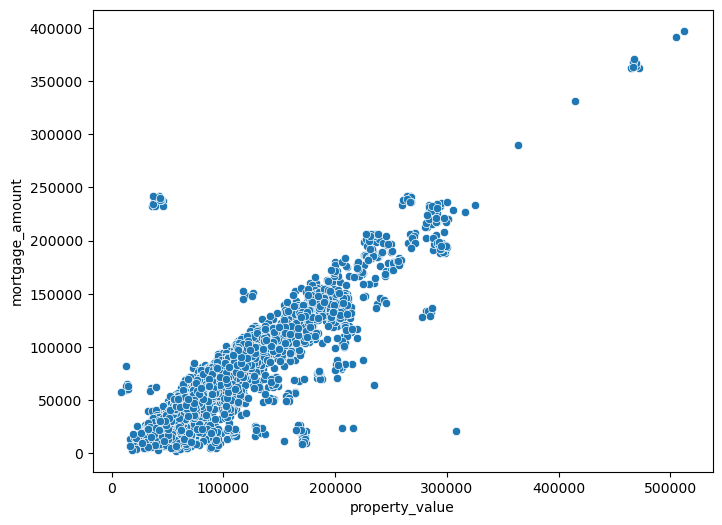

In [68]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = 'property_value',
             y = 'mortgage_amount',
             data = df)

In [69]:
df['LTV_ratio'] = df['mortgage_amount'] / df['property_value']
df['LTV_ratio'].describe()

count    4674.000000
mean        0.709336
std         0.390044
min         0.045699
25%         0.623301
50%         0.717411
75%         0.794214
max         7.162500
Name: LTV_ratio, dtype: float64

We see that the mean and median show LTV ratio is 0.7, hence, we can impute the missing values for 'mortgage_amount' and 'property_value' by the following formula:  
**mortgage_amount = 0.7 * property_value**

In [70]:
def fillna_mortgageAmount(df):
     mortgage = df[0]
     property = df[1]
     if pd.isna(mortgage):
          return 0.7 * property
     else:
          return np.mean(mortgage)

def fillna_property(df):
     mortgage = df[0]
     property = df[1]
     if pd.isna(property):
          return mortgage / 0.7
     else: 
          return np.mean(property)

### t-test

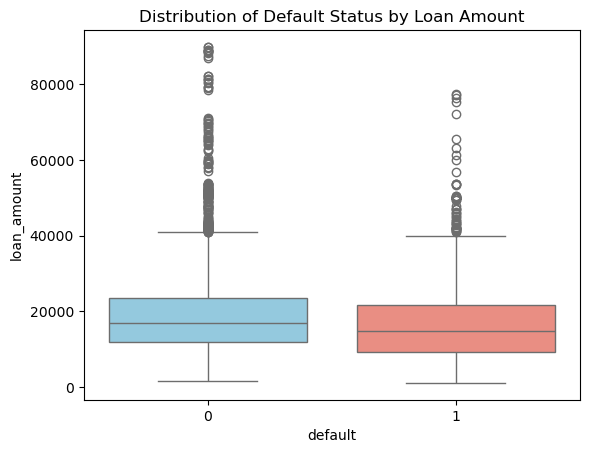

In [71]:
plt.figure()
sns.boxplot(x = 'default', y = 'loan_amount',
            data=df,
            palette=['skyblue', 'salmon'])
plt.title('Distribution of Default Status by Loan Amount')
plt.show()

In [72]:
loan_default = df[df['default'] == 1]['loan_amount']
loan_non_default = df[df['default'] == 0]['loan_amount']

t_stat, p_value = ttest_ind(loan_default,loan_non_default, equal_var=False)
print(f'T-statistic: {t_stat:.3}, P-value: {p_value}')

T-statistic: -5.14, P-value: 3.0736856780213165e-07


Since p-value < 0.05, we can conclude that there is a statistically significant difference in loan amount between defaulters and non-defaulters. This suggests that loan amount is associated with default status.

### loan_reason & occupation

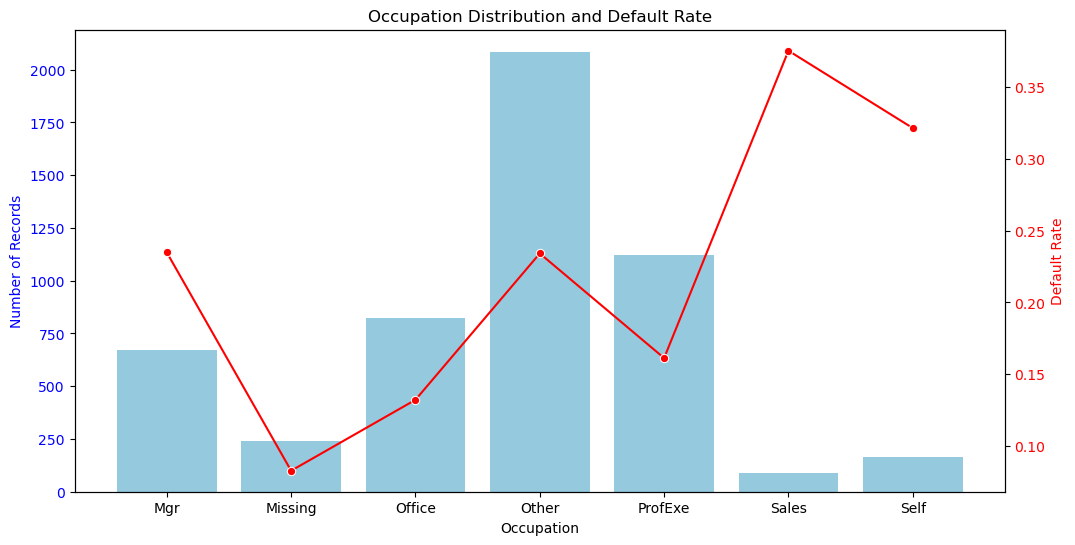

In [73]:
df['occupation_filled'] = df['occupation'].fillna('Missing')

# Calculate counts and default rate
occupation_stats = df.groupby('occupation_filled').agg(
    count=('default', 'size'),
    default_rate=('default', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot for counts (distribution)
sns.barplot(x='occupation_filled', y='count', data=occupation_stats, ax=ax1, color='skyblue')
ax1.set_ylabel('Number of Records', color='blue')
ax1.set_xlabel('Occupation')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis for default rate
ax2 = ax1.twinx()
sns.lineplot(x='occupation_filled', y='default_rate', data=occupation_stats, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Default Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Occupation Distribution and Default Rate")
plt.show()

Though having the least records, 'Sales' and 'Self' pose highest risk to default

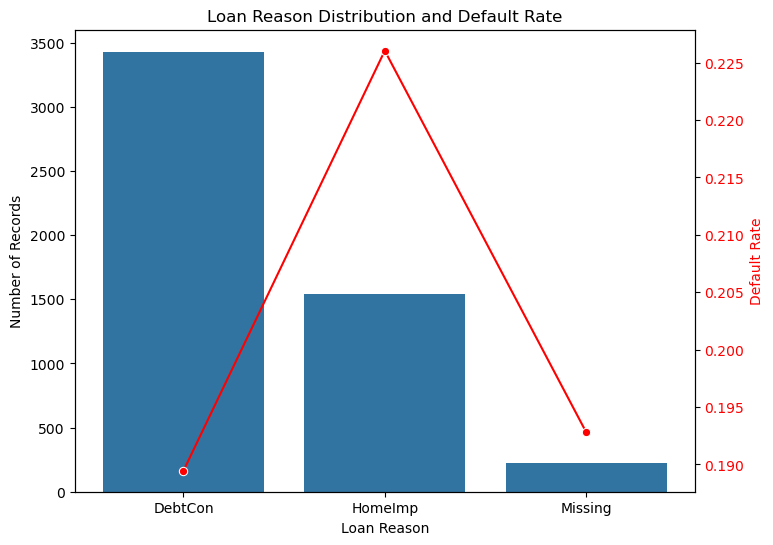

In [74]:
df['loan_reason_filled'] = df['loan_reason'].fillna('Missing')

loan_reason_stat = (df.groupby('loan_reason_filled').agg(
     count = ('default', 'size'),
     default_rate = ('default', 'mean')
)).reset_index()

fig, ax1 = plt.subplots(figsize=(8,6))

# Bar plot for counts
sns.barplot(x = 'loan_reason_filled',
            y = 'count',
            data = loan_reason_stat)
ax1.set_ylabel('Number of Records')
ax1.set_xlabel('Loan Reason')

# Second axis for default rate
ax2 = ax1.twinx()
sns.lineplot(x = 'loan_reason_filled',
             y = 'default_rate',
             data = loan_reason_stat,
             color = 'red',
             marker ='o')
ax2.set_ylabel('Default Rate', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')

plt.title('Loan Reason Distribution and Default Rate')
plt.show()

'HomeImp' pose highest default risk

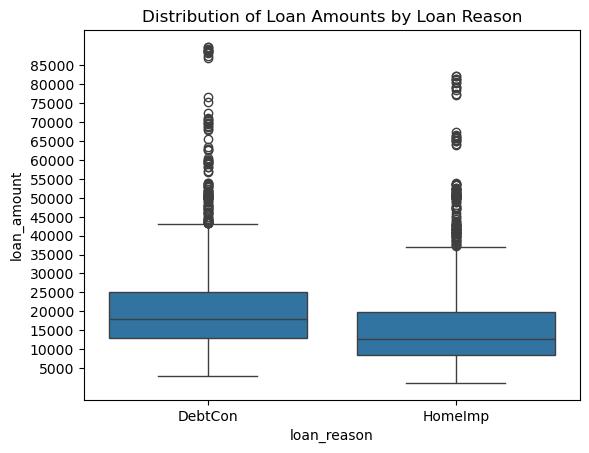

In [75]:
plt.figure()
sns.boxplot(x = 'loan_reason', y = 'loan_amount',
            data=df)
plt.title('Distribution of Loan Amounts by Loan Reason')
plt.yticks(range(5000, 90000, 5000))
plt.show()

- If 'loan_reaon' > 15000 then high chance it's 'DebtCon'  
- If 'loan_reaon' < 15000 then high chacne it's 'HomeImp'

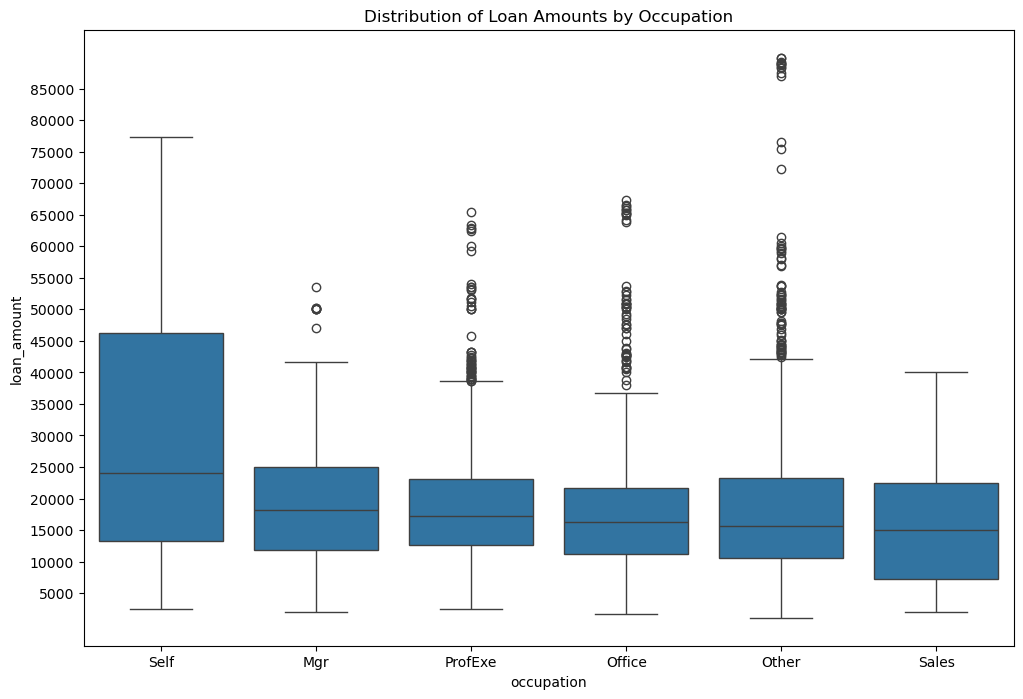

In [76]:
order = (
     df.groupby('occupation')['loan_amount']
     .median()
     .sort_values(ascending=False)
     .index
)
plt.figure(figsize=(12,8))
sns.boxplot(x = 'occupation', y = 'loan_amount',
            data=df,
            order = order)
plt.title('Distribution of Loan Amounts by Occupation')
plt.yticks(range(5000, 90000, 5000))
plt.show()

- 'loan_amount' > 25000 then 'Self'  
- 'loan_amount' < 15000 then 'Sales'
- random other because there is no stand-out pattern.

In [77]:
def fillna_occupation(df):
     occupation = df[0]
     loan_reason = df[1]
     loan_amount = df[2]

     occupation_array = ['Office', 'Other', 'ProfExe', 'Mgr', 'Sales']

     if pd.isna(occupation):
          if loan_amount > 25000:
               return 'Self'
          elif loan_amount < 20000 and loan_reason == 'DebtCon':
               return 'Sales'
          elif loan_amount < 15000 and loan_reason == 'HomeImp':
               return 'Sales'
          else: 
               return random.choice(occupation_array)
     else: return occupation

def fillna_loanReason(df):
     occupation = df[0]
     loan_reason = df[1]
     loan_amount = df[2]

     if pd.isna(loan_reason):
          if occupation == 'Sales':
               return 'DebtCon'
          elif loan_amount > 20000:
               return 'DebtCon'
          else: 
               return 'HomeImp'
     else: 
          return loan_reason
               

### occupation length

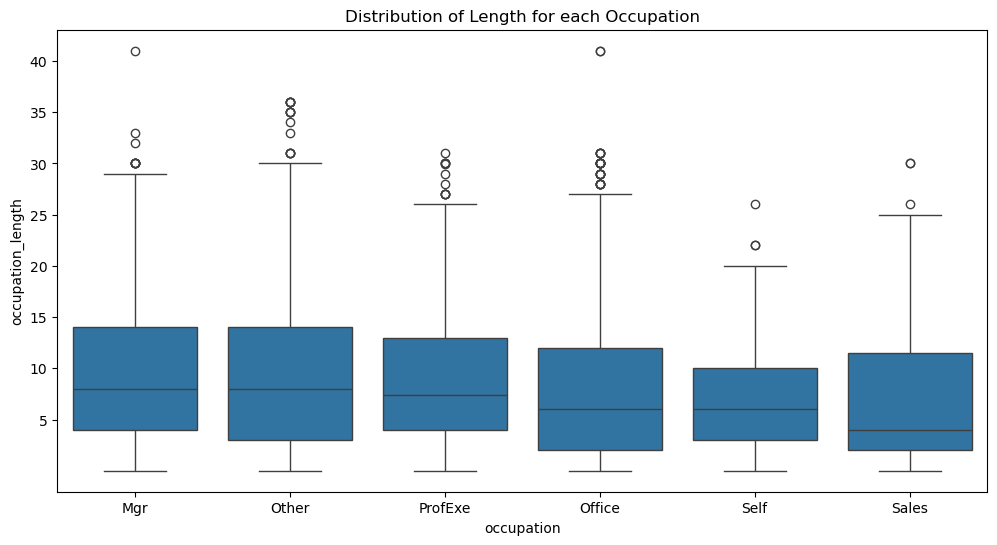

In [78]:
order = (
     df.groupby('occupation')['occupation_length']
     .median()
     .sort_values(ascending=False)
     .index
)
plt.figure(figsize=(12,6))
sns.boxplot(x = 'occupation',
            y = 'occupation_length',
            data = df,
            order=order)
plt.title('Distribution of Length for each Occupation')
plt.yticks(range(5,45,5))
plt.show()

In [79]:
def fillna_occupationLength(df):
     occupation = df[0]
     occupation_length = df[1]

     if pd.isna(occupation_length):
          if occupation == 'Sales':
               return 5
          elif occupation == 'Office' or occupation == 'Self':
               return 6
          else:
               return random.choice([7,8])
     else: return occupation_length

### derogatory_reports & late_payment

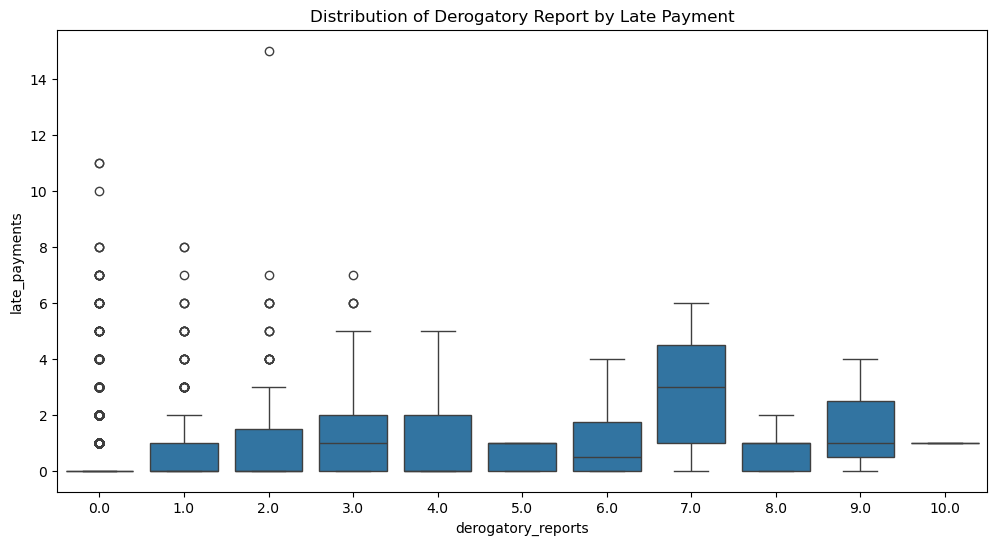

In [80]:
plt.figure(figsize=(12,6))
sns.boxplot(x= 'derogatory_reports',
            y = 'late_payments',
            data = df)
plt.title('Distribution of Derogatory Report by Late Payment')
plt.show()

- The median and spread of late payments tend to increase as derogatory reports increase

In [81]:
def fillna_derogatoryReports(df):
     derogatory_reports = df[0]
     late_payments = df[1]

     if pd.isna(derogatory_reports):
          if late_payments == 0:
               return np.random.choice([0,5])
          if late_payments == 1: 
               return np.random.choice([9,10])
          if late_payments == 2:
               return np.random.choice([1,2,4,6,8])
          if late_payments == 5:
               return 3
          if late_payments == 6:
               return 7
     else:
          return derogatory_reports

def fillna_latePayments(df):
     derogatory_reports = df[0]
     late_payments = df[1]

     if pd.isna(late_payments):
          if derogatory_reports == 0 or derogatory_reports == 5:
               return 0
          elif derogatory_reports in {9,10}:
               return 1
          elif derogatory_reports in {1,2,4,6,8}:
               return 2
          elif derogatory_reports == 3:
               return 5
          else:
               return 6
     else: 
          return late_payments

## Handle Missing Values

In [82]:
def handleMissing(df):
     warnings.filterwarnings("ignore")
     
     df['property_value'] = df[['mortgage_amount', 'property_value']].apply(fillna_property, axis = 1)
     
     df['mortgage_amount'] = df[['mortgage_amount', 'property_value']].apply(fillna_mortgageAmount, axis = 1)
     
     df['occupation'] = df[['occupation', 'loan_reason', 'loan_amount']].apply(fillna_occupation, axis = 1)
     
     df['loan_reason'] = df[['occupation', 'loan_reason', 'loan_amount']].apply(fillna_loanReason, axis = 1)
     
     df['occupation_length'] = df[['occupation', 'occupation_length']].apply(fillna_occupationLength, axis = 1)
     
     df['derogatory_reports'] = df[['derogatory_reports', 'late_payments']].apply(fillna_derogatoryReports, axis = 1)
     
     df['late_payments'] = df[['derogatory_reports', 'late_payments']].apply(fillna_latePayments, axis = 1)

     df['oldest_credit_line'] = df['oldest_credit_line'].fillna(df['oldest_credit_line'].median())
     
     df['recent_credit'] = df['recent_credit'].fillna(df['recent_credit'].median())

     df['credit_number'] = df['credit_number'].fillna(df['credit_number'].median())

     df['ratio'] = df['ratio'].fillna(df['ratio'].median())
     
     return df

df = handleMissing(df)

In [83]:
df.isna().sum()

id                      0
default                 0
loan_amount             0
mortgage_amount        22
property_value         22
loan_reason             0
occupation              0
occupation_length       0
derogatory_reports    472
late_payments           0
oldest_credit_line      0
recent_credit           0
credit_number           0
ratio                   0
LTV_ratio             524
occupation_filled       0
loan_reason_filled      0
dtype: int64

In [84]:
median_values = df[['loan_amount', 'mortgage_amount', 'property_value', 'occupation_length', 
          'derogatory_reports', 'late_payments', 'oldest_credit_line', 'recent_credit', 
          'credit_number', 'ratio']].median()

df[['loan_amount', 'mortgage_amount', 'property_value', 'occupation_length', 
          'derogatory_reports', 'late_payments', 'oldest_credit_line', 'recent_credit', 
          'credit_number', 'ratio']] = df[['loan_amount', 'mortgage_amount', 'property_value', 'occupation_length', 
          'derogatory_reports', 'late_payments', 'oldest_credit_line', 'recent_credit', 
          'credit_number', 'ratio']].fillna(median_values)

df.isna().sum()

id                      0
default                 0
loan_amount             0
mortgage_amount         0
property_value          0
loan_reason             0
occupation              0
occupation_length       0
derogatory_reports      0
late_payments           0
oldest_credit_line      0
recent_credit           0
credit_number           0
ratio                   0
LTV_ratio             524
occupation_filled       0
loan_reason_filled      0
dtype: int64

In [85]:
df = df.drop(columns=['LTV_ratio', 'occupation_filled', 'loan_reason_filled'])
df.head()

,id,default,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,16537,0,20900,58299.0,78684.00,DebtCon,Office,3.0,0.0,0.0,98.662820,0.0,16.0,38.972004
1,14800,0,17400,56111.0,114521.00,HomeImp,Office,2.0,4.0,2.0,154.855524,1.0,24.0,38.695084
2,11317,0,8700,57254.0,86883.00,HomeImp,Other,16.0,0.0,0.0,172.166563,0.0,28.0,25.043437
3,13023,0,6000,69876.0,94394.07,HomeImp,Other,0.0,0.0,1.0,179.566667,0.0,32.0,34.889242
4,11652,0,9700,75566.0,92066.00,DebtCon,Office,14.0,0.0,0.0,94.987922,0.0,8.0,25.161183


## Label Encoding and Standardize

In [86]:
# One-hot Encoding
encoder = OneHotEncoder(sparse_output=False)
categorical_col = df[['occupation', 'loan_reason']]
categorical_col_encoded = encoder.fit_transform(categorical_col)
oneHot_df = pd.DataFrame(categorical_col_encoded, columns = encoder.get_feature_names_out(['occupation', 'loan_reason']))

final_df = pd.concat([df, oneHot_df], axis=1)
final_df = final_df.drop(columns=['loan_reason', 'occupation'])

# Standardize
cols_to_scale = ['loan_amount', 'mortgage_amount', 'property_value', 'oldest_credit_line','ratio', 'occupation_length', 'derogatory_reports']
scaler = StandardScaler()
final_df[cols_to_scale] = scaler.fit_transform(final_df[cols_to_scale])

final_df.head()

,id,default,loan_amount,mortgage_amount,property_value,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio,occupation_Mgr,occupation_Office,occupation_Other,occupation_ProfExe,occupation_Sales,occupation_Self,loan_reason_DebtCon,loan_reason_HomeImp
0,16537,0,0.194200,-0.290811,-0.404656,-0.795489,-0.281807,0.0,-0.974230,0.0,16.0,0.640508,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,14800,0,-0.115025,-0.339033,0.223520,-0.933617,2.521698,2.0,-0.293176,1.0,24.0,0.604520,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,11317,0,-0.883671,-0.313842,-0.260938,1.000169,-0.281807,0.0,-0.083367,0.0,28.0,-1.169625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,13023,0,-1.122217,-0.035659,-0.129279,-1.209872,-0.281807,1.0,0.006322,0.0,32.0,0.109919,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,11652,0,-0.795321,0.089746,-0.170087,0.723914,-0.281807,0.0,-1.018770,0.0,8.0,-1.154322,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [87]:
final_df.to_csv('cleaned_train_data.csv', index=False)

# MODEL TRAINING

In [88]:
X = final_df.iloc[:,2:]
y = final_df.iloc[:,1]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [90]:
parameters = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'C': [1, 5, 10]}
svc_model = SVC(kernel = 'rbf', random_state = 1)
model = GridSearchCV(svc_model, parameters)
model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=1),
             param_grid={'C': [1, 5, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]})

In [91]:
print("These are the best parameter you should choose in your model: ")
print(model.best_params_)
print(model.best_estimator_)

These are the best parameter you should choose in your model: 
{'C': 10, 'gamma': 0.1}
SVC(C=10, gamma=0.1, random_state=1)


In [92]:
# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluating the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9307692307692308
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1254
           1       0.94      0.69      0.80       306

    accuracy                           0.93      1560
   macro avg       0.93      0.84      0.88      1560
weighted avg       0.93      0.93      0.93      1560



# PREDICTION & SUBMISSION

In [93]:
test = pd.read_csv('hmeq_test.csv')
test.head()

,id,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,12816,28100,32470.0,54522.0,DebtCon,Other,35.0,0.0,0.0,295.496684,0.0,23.0,38.799483
1,11678,10500,57880.0,66802.0,DebtCon,Other,2.0,0.0,0.0,94.598425,8.0,21.0,45.464766
2,13568,10900,NaN,76207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.392612
3,16525,50000,44000.0,59000.0,DebtCon,Office,12.0,0.0,1.0,102.500000,2.0,26.0,NaN
4,16160,7500,NaN,26850.0,HomeImp,Office,20.0,0.0,0.0,185.633333,1.0,16.0,NaN


In [94]:
test.isna().sum()

id                      0
loan_amount             0
mortgage_amount        67
property_value         17
loan_reason            29
occupation             38
occupation_length      65
derogatory_reports     89
late_payments          77
oldest_credit_line     41
recent_credit          74
credit_number          26
ratio                 154
dtype: int64

In [95]:
test = handleMissing(test)
test.head()

,id,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,12816,28100,32470.0,54522.0,DebtCon,Other,35.0,0.0,0.0,295.496684,0.0,23.0,38.799483
1,11678,10500,57880.0,66802.0,DebtCon,Other,2.0,0.0,0.0,94.598425,8.0,21.0,45.464766
2,13568,10900,53344.9,76207.0,HomeImp,Other,8.0,NaN,6.0,171.679811,1.0,20.0,22.392612
3,16525,50000,44000.0,59000.0,DebtCon,Office,12.0,0.0,1.0,102.500000,2.0,26.0,34.471621
4,16160,7500,18795.0,26850.0,HomeImp,Office,20.0,0.0,0.0,185.633333,1.0,16.0,34.471621


In [96]:
test.isna().sum()

id                     0
loan_amount            0
mortgage_amount        5
property_value         5
loan_reason            0
occupation             0
occupation_length      0
derogatory_reports    72
late_payments          0
oldest_credit_line     0
recent_credit          0
credit_number          0
ratio                  0
dtype: int64

In [97]:
median_values = test[['mortgage_amount', 'property_value', 'derogatory_reports',
                    'late_payments', 'oldest_credit_line', 'recent_credit',
                    'credit_number', 'ratio']].median()

# Replace NaNs with the median value in each column
test[['mortgage_amount', 'property_value', 'derogatory_reports',
    'late_payments', 'oldest_credit_line', 'recent_credit',
    'credit_number', 'ratio']] = test[['mortgage_amount', 'property_value', 'derogatory_reports',
                                     'late_payments', 'oldest_credit_line', 'recent_credit',
                                     'credit_number', 'ratio']].fillna(median_values)

In [98]:
# One-hot Encoding
categorical_col = test[['occupation', 'loan_reason']]
categorical_col_encoded = encoder.fit_transform(categorical_col)
oneHot_test = pd.DataFrame(categorical_col_encoded, columns= encoder.get_feature_names_out(['occupation', 'loan_reason']))

final_test_df = pd.concat([test, oneHot_test], axis=1)
final_test_df = final_test_df.drop(columns=['loan_reason', 'occupation'])

# Standardize
cols_to_scale = ['loan_amount', 'mortgage_amount', 'property_value', 'oldest_credit_line','ratio', 'occupation_length', 'derogatory_reports']
scaler = StandardScaler()
final_test_df[cols_to_scale] = scaler.fit_transform(final_test_df[cols_to_scale])

final_test_df.head()

,id,loan_amount,mortgage_amount,property_value,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio,occupation_Mgr,occupation_Office,occupation_Other,occupation_ProfExe,occupation_Sales,occupation_Self,loan_reason_DebtCon,loan_reason_HomeImp
0,12816,0.975509,-0.799224,-0.759802,3.534627,-0.295885,0.0,1.254267,0.0,23.0,0.693912,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,11678,-0.718862,-0.276939,-0.562271,-0.918589,-0.295885,0.0,-0.967483,8.0,21.0,1.608496,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,13568,-0.680353,-0.370155,-0.410986,-0.108913,-0.295885,6.0,-0.115034,1.0,20.0,-1.557374,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,16525,3.083845,-0.562233,-0.687771,0.430871,-0.295885,1.0,-0.880098,2.0,26.0,0.100060,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,16160,-1.007675,-1.080304,-1.204923,1.510438,-0.295885,0.0,0.039279,1.0,16.0,0.100060,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [99]:
pred_final_test_df = final_test_df.drop(['id'], axis = 1)
pred_final_test_df

,loan_amount,mortgage_amount,property_value,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio,occupation_Mgr,occupation_Office,occupation_Other,occupation_ProfExe,occupation_Sales,occupation_Self,loan_reason_DebtCon,loan_reason_HomeImp
0,0.975509,-0.799224,-0.759802,3.534627,-0.295885,0.0,1.254267,0.0,23.0,0.693912,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.718862,-0.276939,-0.562271,-0.918589,-0.295885,0.0,-0.967483,8.0,21.0,1.608496,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.680353,-0.370155,-0.410986,-0.108913,-0.295885,6.0,-0.115034,1.0,20.0,-1.557374,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3.083845,-0.562233,-0.687771,0.430871,-0.295885,1.0,-0.880098,2.0,26.0,0.100060,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.007675,-1.080304,-1.204923,1.510438,-0.295885,0.0,0.039279,1.0,16.0,0.100060,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,0.677069,0.218831,0.427364,-0.243859,-0.295885,1.0,-1.901588,1.0,41.0,0.100060,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
758,0.523035,0.367356,0.287081,-0.783643,-0.295885,0.0,0.437938,1.0,26.0,0.111666,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
759,-0.256761,-1.027109,-1.017848,1.510438,-0.295885,1.0,0.005734,4.0,31.0,0.100060,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
760,-0.959539,0.107838,-0.092604,-0.918589,-0.295885,0.0,-1.205972,2.0,24.0,0.100060,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [101]:
y_pred = model.predict(pred_final_test_df)

In [111]:
predicted_df = pd.DataFrame({
     'id': final_test_df.iloc[:,0],
     'default': y_pred
})

print(predicted_df)

        id  default
0    12816        0
1    11678        1
2    13568        0
3    16525        0
4    16160        0
..     ...      ...
757  16196        1
758  16461        0
759  16619        1
760  12593        0
761  16388        0

[762 rows x 2 columns]


In [112]:
predicted_df.to_csv('submission.csv', index=False)